<a href="https://colab.research.google.com/github/mso13/BrazilianFinancialNews/blob/main/hyperas_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
print (os.curdir)
!ls

.
adc.json  drive  lstm-test-2.ipynb  __pycache__  sample_data


In [2]:
!pip install hyperas

In [3]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics

from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import _locale 
_locale._getdefaultlocale = (lambda *args: ['en_US', 'utf8'])

In [4]:
json_data_path = './drive/MyDrive/UnB/Mestrado/Text_Classification/data/results-full-suno-2020.json'

with open(json_data_path, 'r', encoding='utf8') as json_file:
    data = json.load(json_file)

df_suno = pd.DataFrame(data)

print (df_suno.head())

               topic  ...                                               tags
0            Mercado  ...                                         [ibovespa]
1  Finanças pessoais  ...  [ABEV3, Ambev, EGIE3, Engie, Hering, HGTX3, Lo...
2           Negócios  ...  [BBDC3, BBDC4, Bradesco, juros sobre o capital...
3           Negócios  ...                              [paranapanema, PMAM3]
4      Internacional  ...       [livros sobre investimentos, Warren Buffett]

[5 rows x 6 columns]


In [5]:
def data():
    
    # 1. Load the dataset
    json_data_path = './drive/MyDrive/UnB/Mestrado/Text_Classification/data/results-full-suno-2020.json'

    with open(json_data_path, 'r', encoding='utf8') as json_file:
        data = json.load(json_file)

    df_suno = pd.DataFrame(data)
    
    # Convert date to datetime format
    df_suno['date'] = pd.to_datetime(df_suno['date'], format='%d/%m/%Y %H:%M')

    # Set date column as index
    df_suno.set_index('date', inplace=True)

    # Order by date
    df_suno.sort_index(inplace=True)
    
    # Convert text columns to string
    df_suno['title'] = df_suno['title'].astype('string')
    df_suno['full_text'] = df_suno['full_text'].astype('string')
    
    # Extract main columns
    df_suno = df_suno[['title', 'full_text', 'topic']]
    
    # Select main topics
    df_suno = df_suno[df_suno['topic'].isin(['Mercado', 'Economia', 'Internacional', 'Negócios'])]
    
    # 2. Preprocessing
    def remove_emojis(sentence):

        "Remoção de Emojis nas mensagens de texto."

        # Padrões dos Emojis
        emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    u"\U0001f926-\U0001f937"
                    u'\U00010000-\U0010ffff'
                    u"\u200d"
                    u"\u2640-\u2642"
                    u"\u2600-\u2B55"
                    u"\u23cf"
                    u"\u23e9"
                    u"\u231a"
                    u"\u3030"
                    u"\ufe0f"
        "]+", flags=re.UNICODE)

        return emoji_pattern.sub(r'', sentence)

    def remove_valores(sentence):
        new_sentece = ''

        for token in sentence.split():
            if token.isdigit():
                token = '<NUM>'
            new_sentece += ' {}'.format(token)

        return new_sentece

    # Substituir símbolos importantes
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('-feira', ''))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('+', 'mais '))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('-', 'menos '))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('%', ' por cento'))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('R$', ''))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('U$', ''))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('US$', ''))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('S&P 500', 'spx'))

    # Transformar em String e Letras Minúsculas nas Mensagens
    df_suno['title'] = df_suno['title'].map(lambda s: str(s).lower())

    # Remover Pontuações
    df_suno['title'] = df_suno['title'].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

    # Remover Emojis     
    df_suno['title'] = df_suno['title'].map(lambda s: remove_emojis(s))

    # Quebras de Linha desnecessárias
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('\n', ' '))

    # Remover aspas duplas
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('\"', ''))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('“', ''))
    df_suno['title'] = df_suno['title'].map(lambda s: s.replace('”', ''))

    # Remover valores
    df_suno['title'] = df_suno['title'].map(lambda s: remove_valores(s))

    # Espaços desnecessários
    df_suno['title'] = df_suno['title'].map(lambda s: s.strip())
    
    # Extract titles
    samples = df_suno['title'].values
    
    # Transformar os tópicos em números inteiros
    label_encoder = preprocessing.LabelEncoder()
    df_suno['topic_number'] = label_encoder.fit_transform(df_suno['topic'])
    class_names = label_encoder.classes_
    
    # Extract labels
    labels = df_suno['topic_number'].values
    
    # Split Train/Test sets (80% Train / 20% Test --> Used for final metrics)
    seed = 1337
    rng = np.random.RandomState(seed)
    rng.shuffle(samples)
    rng = np.random.RandomState(seed)
    rng.shuffle(labels)

    validation_split = 0.2
    num_validation_samples = int(validation_split * len(samples))
    train_samples = samples[:-num_validation_samples]
    val_samples = samples[-num_validation_samples:]
    train_labels = labels[:-num_validation_samples]
    val_labels = labels[-num_validation_samples:]
    
    # Convert to number vector
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

    MAX_SEQUENCE_LENGTH = 200

    vectorizer = TextVectorization(max_tokens=20000, 
                                   output_sequence_length=MAX_SEQUENCE_LENGTH)
    text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(32)
    vectorizer.adapt(text_ds)
    
    # Define the vocabulary
    voc = [w for w in vectorizer.get_vocabulary()]
    word_index = dict(zip(voc, range(len(voc))))
    
    # Load pre-trained GloVe Embeddings
    path_to_glove_file = 'drive/MyDrive/UnB/Mestrado/Text_Classification/data/full_text_financial_news_vectors.txt'

    embeddings_index = {}
    with open(path_to_glove_file, encoding='utf8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))
    
    # Map words to vectors
    num_tokens = len(voc) + 2
    embedding_dim = 300
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    # Apply transformations to train/valid. sets
    x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
    x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

    y_train = np.array(train_labels)
    y_val = np.array(val_labels)

    x_test = x_val
    y_test = y_val
    
    return x_train, y_train, x_test, y_test

In [6]:
def create_model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )

    # This callback will stop the training when there is no improvement in  
    # the validation loss for five consecutive epochs.  
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            mode='min', 
                                            verbose=1, 
                                            patience=10)

    int_sequences_input = keras.Input(shape=(None,))
    embedded_sequences = embedding_layer(int_sequences_input)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM({{choice([8, 16, 32, 64, 128])}},  return_sequences=True))(embedded_sequences)
    x = tf.keras.layers.Dropout({{uniform(0, 1)}})(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM({{choice([8, 16, 32, 64, 128])}}))(x)
    x = tf.keras.layers.Dense({{choice([8, 16, 32, 64, 128])}}, activation={{choice(['relu', 'tanh'])}})(x)
    x = tf.keras.layers.Dropout({{uniform(0, 1)}})(x)
    preds = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

    model = keras.Model(int_sequences_input, preds)
    
    # Compile and Fit
    model.compile(
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'],
        optimizer={{choice(['adam', 'sgd', 'rmsprop'])}})
    
    # 80% from X_train for training / 20% for Validation
    result = model.fit(x_train, 
                       y_train,
                       epochs=50,
                       batch_size=32,
                       verbose=2,
                       validation_split=0.2, 
                       callbacks=[callback])  
    
    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_accuracy']) 
    print('Best validation acc of epoch:', validation_acc)


    return {'loss': -validation_acc, 
            'status': STATUS_OK, 
            'model': model,  
            'history.val_loss':result.history['val_loss'], 
            'history.val_acc': result.history['val_accuracy'],
            'history.loss': result.history['loss'], 
            'history.acc': result.history['accuracy']}

In [7]:
# See: https://stackoverflow.com/questions/49920031/get-the-path-of-the-notebook-on-google-colab
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid_obj = drive.ListFile({'q':"title='hyperas-lstm.ipynb'"}).GetList()
fid = fid_obj[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('hyperas-lstm.ipynb')

In [8]:
trials = Trials()

import time
start = time.time()

best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      trials=trials,
                                      notebook_name="hyperas-lstm")  

X_train, Y_train, X_test, Y_test = data()

print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

end = time.time()

print('Elapsed Time: {:.2f} segundos'.format(end - start))

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import os
except:
    pass

try:
    import re
except:
    pass

try:
    import json
except:
    pass

try:
    import string
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn import preprocessing
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:


In [9]:
print (best_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         2916600   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 32)          40576     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0     

In [10]:
print(best_model.optimizer.lr)

<tf.Variable 'RMSprop/learning_rate:0' shape=() dtype=float32, numpy=0.001>


In [11]:
classes = ['Economia', 'Internacional', 'Mercado', 'Negócios']

predicted = best_model.predict(X_test)

Y_predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(Y_test, Y_predicted, target_names=classes))
print('Acurácia: {}'.format(metrics.accuracy_score(Y_test, Y_predicted)))

               precision    recall  f1-score   support

     Economia       0.71      0.84      0.77       436
Internacional       0.79      0.77      0.78       445
      Mercado       0.87      0.76      0.81       762
     Negócios       0.89      0.90      0.90      1733

     accuracy                           0.84      3376
    macro avg       0.81      0.82      0.81      3376
 weighted avg       0.85      0.84      0.84      3376

Acurácia: 0.8444905213270142


In [12]:
results = trials.results
print (results[0])

{'loss': -0.8493150472640991, 'status': 'ok', 'model': <tensorflow.python.keras.engine.functional.Functional object at 0x7f4197683fd0>, 'history.val_loss': [0.6225135922431946, 0.5477192401885986, 0.5563231706619263, 0.5012772679328918, 0.4897155463695526, 0.4817686378955841, 0.4877009093761444, 0.47704607248306274, 0.49468639492988586, 0.5145567655563354, 0.4960285425186157, 0.48867759108543396, 0.5820659399032593, 0.5302350521087646, 0.5175132155418396, 0.4964001774787903, 0.5158591270446777, 0.519615888595581], 'history.val_acc': [0.8148833513259888, 0.830433189868927, 0.830433189868927, 0.840059220790863, 0.8456127643585205, 0.8426508903503418, 0.8437615633010864, 0.8459829688072205, 0.8407996892929077, 0.837467610836029, 0.8433913588523865, 0.8393187522888184, 0.8271010518074036, 0.837467610836029, 0.8333950638771057, 0.8363568782806396, 0.8493150472640991, 0.8333950638771057], 'history.loss': [0.8438761830329895, 0.7172828912734985, 0.6735120415687561, 0.6363197565078735, 0.61496

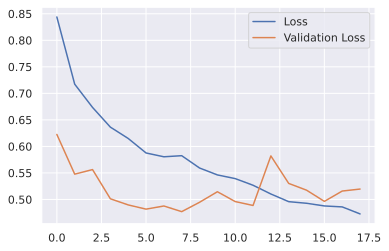

In [18]:
# Loss / Iteration
sns.set(style='darkgrid')

plt.plot(results[0]['history.loss'], label='Loss')
plt.plot(results[0]['history.val_loss'], label='Validation Loss')
plt.legend()

plt.savefig('plot-loss', format='png', quality=100)
plt.show()

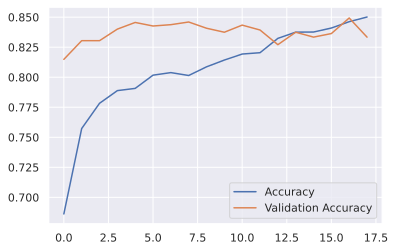

In [19]:
# Accuracy / Iteration
plt.plot(results[0]['history.acc'], label='Accuracy')
plt.plot(results[0]['history.val_acc'], label='Validation Accuracy')
plt.legend()
plt.savefig('plot-accuracy.png', format='png', quality=100)
plt.show()

In [15]:
best_model.save('drive/MyDrive/UnB/Mestrado/Text_Classification/best_model-layer_128-epochs_15_2----teste2')

INFO:tensorflow:Assets written to: drive/MyDrive/UnB/Mestrado/Text_Classification/best_model-layer_128-epochs_15_2----teste2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/UnB/Mestrado/Text_Classification/best_model-layer_128-epochs_15_2----teste2/assets
